# Preprocessing gene expression from TCGA
In this notebook, I want to compute a matrix $S \in \mathbb{R}^{p \times s}$ where $s$ is the number of samples and $p$ is the number of genes. In a second step, I want to use information about the cancer type of each of the samples to aggregate the matrix to a different matrix $S_{mean} \in \mathbb{R}^{p\times c}$ where $c$ corresponds to the number of cancer types under investigation.

In [1]:
import pandas as pd
import numpy as np
import h5py, os, sys
import mygene
import matplotlib.pyplot as plt
plt.rc('font', family='Times New Roman')
import seaborn
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

/home/sasse/.local/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [20]:
# PARAMETERS
use_foldchanges = True
max_reads = 100

## Load the downloaded Data to Dataframes
I downloaded all the gene expression data from TCGA into one download directory. I now have to walk through that and load the contents to a dataframe.

Then, I join all of the dataframes together to obtain $S$.

In [3]:
def get_filenames(ge_dir):
    """Extract all valid gene expression files in dir.
    """
    all_filenames = []
    for dname in os.listdir(ge_dir):
        sub_dirname = os.path.join(ge_dir, dname)
        if os.path.isdir(sub_dirname):
            for fname in os.listdir(sub_dirname):
                if fname.endswith('.FPKM.txt.gz'):
                    all_filenames.append(os.path.join(sub_dirname, fname))
    print ("Collected {} gene expression files".format(len(all_filenames)))
    return all_filenames

names = get_filenames('../../data/pancancer/TCGA/expression/download/')

Collected 5946 gene expression files


In [4]:
path_sample_matrix = '../../data/pancancer/TCGA/expression/sample_matrix_geneexpression.tsv'

if not os.path.exists(path_sample_matrix):
    all_dfs = []
    for fname in names:
        ge_df = pd.read_csv(fname, compression='gzip', sep='\t', header=None, names=['ID', os.path.basename(fname)])
        ge_df.set_index('ID', inplace=True)
        all_dfs.append(ge_df)
    print ("Collected {} DataFrames corresponding to a RNA-seq experiment each".format(len(all_dfs)))
    sample_matrix = pd.concat(all_dfs, axis=1)
    print ("Concatenated experiments to obtain sample matrix of shape {}".format(sample_matrix.shape))
    sample_matrix.to_csv(path_sample_matrix, sep='\t', compression='gzip')
else:
    print ("Reading Data Matrix from disk...")
    sample_matrix = pd.read_csv(path_sample_matrix, sep='\t')

In [5]:
sample_matrix.head()

,ID,6449f2b6-1af9-4612-abde-ac0f5bb1ff7e.FPKM.txt.gz,d7e7ad52-ecde-4744-b4e7-28dea4d186da.FPKM.txt.gz,b57f69a6-91ca-4131-a654-5495f6dd1131.FPKM.txt.gz,591271df-af96-4915-9e17-e3362bb7f57d.FPKM.txt.gz,56aa923f-bbcd-427f-9542-21518ed22939.FPKM.txt.gz,26f62491-75cf-402b-af7a-663d4458ea17.FPKM.txt.gz,a12ff0ad-8580-4cec-9e63-1175335f0316.FPKM.txt.gz,027ec9be-7e41-44df-8f61-1e5698303eac.FPKM.txt.gz,c45fe186-f0ba-4017-a8f6-a511c1b000eb.FPKM.txt.gz,...,2723b8fe-33ae-477f-ab0d-f5685f26b17f.FPKM.txt.gz,3788684a-b405-44fe-8d09-4e40a46d5214.FPKM.txt.gz,35a1df51-9daf-4d8b-ab87-222b8562244a.FPKM.txt.gz,2358eba8-2134-4fa7-8177-b8919197f014.FPKM.txt.gz,25577d95-744c-45a8-b84a-a9c1b51c2baf.FPKM.txt.gz,46c4b927-c29c-4dbe-90a4-a493c37188df.FPKM.txt.gz,71550bf2-086d-46ac-aee3-958bbac2d2ab.FPKM.txt.gz,d8f882f6-d25a-42dc-9444-02e1d8cb7608.FPKM.txt.gz,ac32a9f2-e148-4e70-899e-78b8ae563839.FPKM.txt.gz,c1ffe8f9-b01b-42c4-b49d-0ceba6cf19c9.FPKM.txt.gz
0,ENSG00000242268.2,0.062428,0.059983,0.000000,0.113754,0.000000,0.000000,0.000000,0.020097,0.000000,...,0.025213,0.604993,0.179464,0.000000,0.000000,0.000000,0.123045,0.000000,0.000000,0.000000
1,ENSG00000270112.3,0.000000,0.008323,0.000000,0.006314,0.000000,0.000000,0.000000,0.000000,0.010306,...,0.003498,0.000000,0.000000,0.000000,0.020744,0.039274,0.002845,0.695735,0.000000,0.000000
2,ENSG00000167578.15,4.295036,1.478366,3.678589,0.984695,6.071861,3.957672,3.497561,4.345583,1.654261,...,2.523523,6.306949,3.026097,5.262676,2.388734,3.328121,3.491212,7.587639,1.132913,4.776581
3,ENSG00000273842.1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,ENSG00000078237.5,6.532015,1.606022,5.058882,1.966371,5.022212,2.890164,5.025476,3.502354,1.870948,...,4.139221,2.484322,3.709208,3.749365,1.882028,2.938333,3.116275,1.443302,9.950534,4.766567


In [6]:
fname_2_ctype = pd.read_json('../../data/pancancer/TCGA/expression/meta_tcga_data/files.2018-07-23.json')

# extract cancer type and put it as extra column
ctypes = [dict(i)['project']['project_id'].split('-')[1].strip() for i in fname_2_ctype.cases.str[0]]
fname_2_ctype['cancertype'] = ctypes

# extract case ID and put it as extra column
case_ids = [dict(i)['case_id'] for i in fname_2_ctype.cases.str[0]]
fname_2_ctype['case_ID'] = case_ids

# now, join with sample file to get the TCGA barcodes (allows us to get some more information on tissue, normal or tumor etc)
sample_info = pd.read_csv('../../data/pancancer/TCGA/expression/meta_tcga_data/sample.tsv', sep='\t')
sample_info.shape, fname_2_ctype.shape

((16150, 27), (5946, 9))

In [7]:
merged = fname_2_ctype.merge(sample_info, left_on='case_ID', right_on='case_id')
cols_of_interest = ['file_name', 'cancertype', 'case_ID', 'sample_id', 'sample_submitter_id', 'case_id', 'case_submitter_id', 'project_id', 'sample_type_id', 'tumor_code_id', 'tumor_code', 'tissue_type', 'sample_type']
merged[merged.case_id == '2779fa01-ac93-4e80-a997-3385f72172c3'][cols_of_interest]

,file_name,cancertype,case_ID,sample_id,sample_submitter_id,case_id,case_submitter_id,project_id,sample_type_id,tumor_code_id,tumor_code,tissue_type,sample_type
5,ed4ae015-8f5e-49b5-886d-e8489ca1b013.FPKM.txt.gz,BRCA,2779fa01-ac93-4e80-a997-3385f72172c3,960d194f-fe39-42a0-831d-5c031cf93544,TCGA-A8-A08S-01A,2779fa01-ac93-4e80-a997-3385f72172c3,TCGA-A8-A08S,TCGA-BRCA,1,--,--,--,Primary Tumor
6,ed4ae015-8f5e-49b5-886d-e8489ca1b013.FPKM.txt.gz,BRCA,2779fa01-ac93-4e80-a997-3385f72172c3,793be994-dedd-4a82-a409-89e0832abf23,TCGA-A8-A08S-10A,2779fa01-ac93-4e80-a997-3385f72172c3,TCGA-A8-A08S,TCGA-BRCA,10,--,--,--,Blood Derived Normal
7,ed4ae015-8f5e-49b5-886d-e8489ca1b013.FPKM.txt.gz,BRCA,2779fa01-ac93-4e80-a997-3385f72172c3,24dca296-fa30-4314-ae88-e017c8a48bad,TCGA-A8-A08S-01Z,2779fa01-ac93-4e80-a997-3385f72172c3,TCGA-A8-A08S,TCGA-BRCA,1,FFPE,--,--,--


## Derive Cancer Types using json file with meta information
I donwloaded a json file containing some information about all the files that were downloaded before. This can now be used to infer the cancer type of each of the samples. Furthermore, I can query the GDC API and get some meta information about the data. For instance, I can see if the RNA-seq comes from control or tumor samples and which sample it belongs to.

Using that mapping information, I can construct the matrix $S_{mean}$ and save it to disk.

In [8]:
fname_2_ctype = pd.read_json('../../data/pancancer/TCGA/expression/meta_tcga_data/files.2018-07-23.json')

# extract cancer type and put it as extra column
ctypes = [dict(i)['project']['project_id'].split('-')[1].strip() for i in fname_2_ctype.cases.str[0]]
fname_2_ctype['cancertype'] = ctypes

# remove everything else
fname_2_ctype = fname_2_ctype[['file_name', 'cancertype']]
fname_2_ctype.set_index('file_name', inplace=True)

In [9]:
def makeParams(file_ids):
    params ={
        "filters":{
            "op":"in",
            "content":{
                "field":"files.file_id",
                "value":file_ids
            }
        },
        "format":"TSV",
        "fields":"file_id,file_name,cases.case_id,cases.submitter_id,cases.samples.sample_id,cases.samples.submitter_id,cases.samples.sample_type,cases.samples.tissue_type",
        "size":len(file_ids)
    }
    return params


def gdcAPI(file_ids):
    files_endpt = "https://api.gdc.cancer.gov/files"
    params = makeParams(file_ids)
    response = requests.post(files_endpt, json = params)
    return response


manifest = pd.read_csv('../../data/pancancer/TCGA/expression/gdc_manifest_relevanttypes_fpkm_2018_07_23.txt', sep='\t')
list_of_ids = manifest.id.tolist()
mapping_file = '../../data/pancancer/TCGA/expression/meta_tcga_data/filename_mapping.tsv'
if not os.path.exists(mapping_file):
    response = gdcAPI(list_of_ids)
    with open(mapping_file, 'w') as f:
        f.write(response.text)
mapping = pd.read_csv(mapping_file, sep='\t', names=['sample_type', 'tissue_type', 'file_name', 'submitter_id', 'sample_id', 'file_id', 'submitter_id2', 'case_id', 'id'], header=0)
mapping['sample_type_simple'] = ['tumor' if i[3].startswith('0') else 'normal' for i in mapping.submitter_id.str.split('-')]
mapping.sample_type_simple.value_counts()

# get the cancer type as well
meta_data = mapping.join(fname_2_ctype, on='file_name')

In [10]:
tumor_cols = meta_data[meta_data.sample_type_simple == 'tumor'].file_name
normal_cols = meta_data[meta_data.sample_type_simple == 'normal'].file_name

In [11]:
sample_matrix[tumor_cols].shape, sample_matrix[normal_cols].shape

((53360, 5499), (53360, 447))

In [12]:
tumor_sample_mat = sample_matrix[tumor_cols]
normal_sample_mat = sample_matrix[normal_cols]

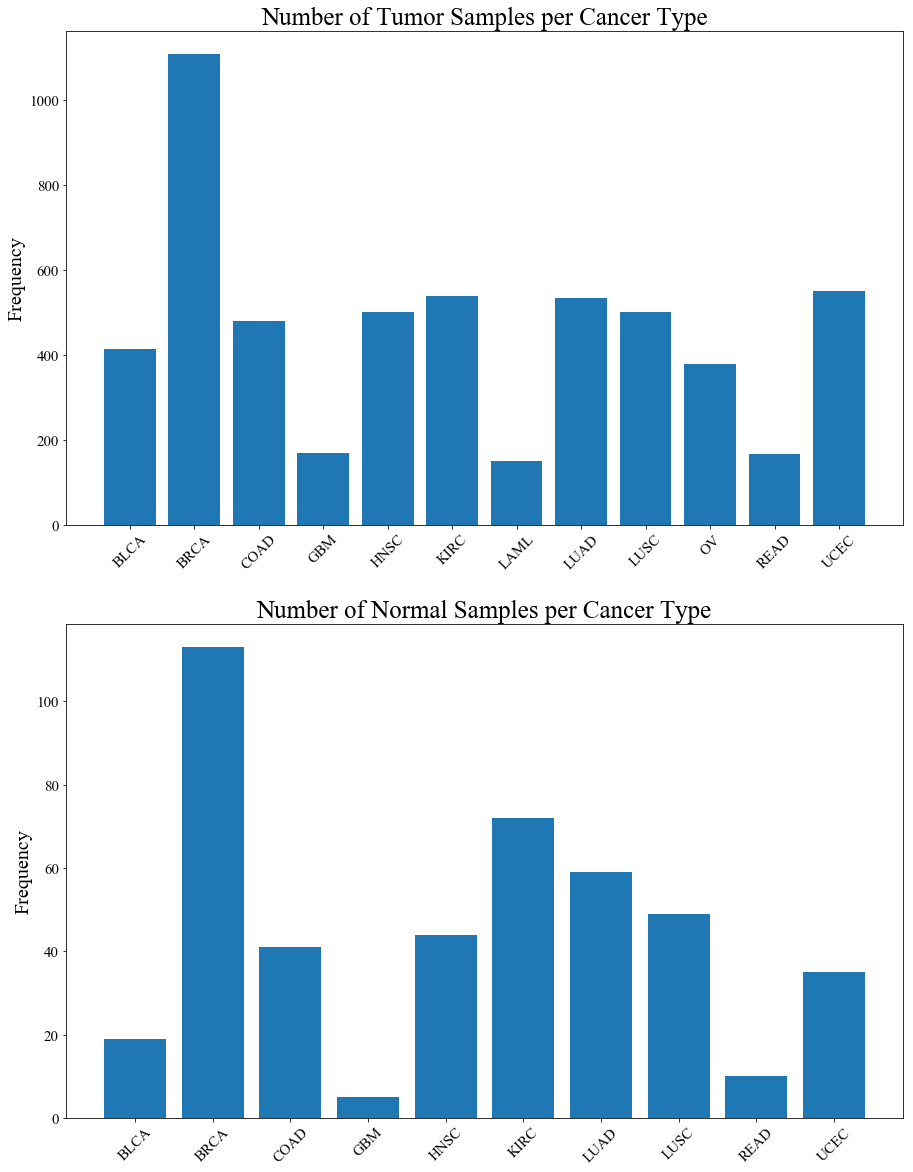

In [13]:
unique, counts = np.unique(meta_data[meta_data.sample_type_simple == 'tumor'].cancertype, return_counts=True)
fig = plt.figure(figsize=(15, 20))
plt.subplot(2, 1, 1)
ax = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Number of Tumor Samples per Cancer Type', fontsize=25)
plt.subplot(2, 1, 2)
unique, counts = np.unique(meta_data[meta_data.sample_type_simple == 'normal'].cancertype, return_counts=True)
ax = plt.bar(np.arange(counts.shape[0]), counts)
plt.xticks(np.arange(counts.shape[0]), unique, rotation=45, fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Frequency', fontsize=20)
plt.title('Number of Normal Samples per Cancer Type', fontsize=25)
fig.savefig('../../data/pancancer/TCGA/expression/samples_per_cancertype.svg')

In [14]:
m = meta_data[['file_name', 'cancertype', 'sample_type_simple']].set_index('file_name')
samples_with_ctype = sample_matrix.T.join(m)

In [15]:
meta_data[meta_data.submitter_id.str.startswith('TCGA-20-1687')]

,sample_type,tissue_type,file_name,submitter_id,sample_id,file_id,submitter_id2,case_id,id,sample_type_simple,cancertype
5310,Primary Tumor,NaN,d143ba0b-3878-428d-9432-2a179a9abf8c.FPKM.txt.gz,TCGA-20-1687-01A,bcd16bf3-0877-4e4b-b70b-7d6a497af7ac,756203dc-4d95-4efc-943a-3429cd252541,TCGA-20-1687,9bf16a89-2fc7-4c08-93bc-3105eec5c3cc,756203dc-4d95-4efc-943a-3429cd252541,tumor,OV


## Filter out genes that have unrealistically high gene expression
To get rid of this strange behaviour in the boxplot, it might be a good idea to kick out genes that have unrealistic gene expression.

In [16]:
# save the IDs
t = samples_with_ctype.drop(['cancertype', 'sample_type_simple'], axis=1, errors='ignore')[samples_with_ctype.index == 'ID']

# compute mean and re-introduce the IDs
mean_ge_tumor = samples_with_ctype[samples_with_ctype.sample_type_simple == 'tumor'].fillna(0).groupby('cancertype').mean().T
mean_ge_tumor['ID'] = t.T
mean_ge_tumor.set_index('ID', inplace=True)
mean_ge_tumor_filtered = mean_ge_tumor[mean_ge_tumor.max(axis=1) < max_reads]

In [17]:
mean_ge_normal = samples_with_ctype[samples_with_ctype.sample_type_simple == 'normal'].fillna(0).groupby('cancertype').mean().T
mean_ge_normal['ID'] = t.T
mean_ge_normal.set_index('ID', inplace=True)
mean_ge_normal_filtered = mean_ge_normal[mean_ge_normal.max(axis=1) < max_reads]

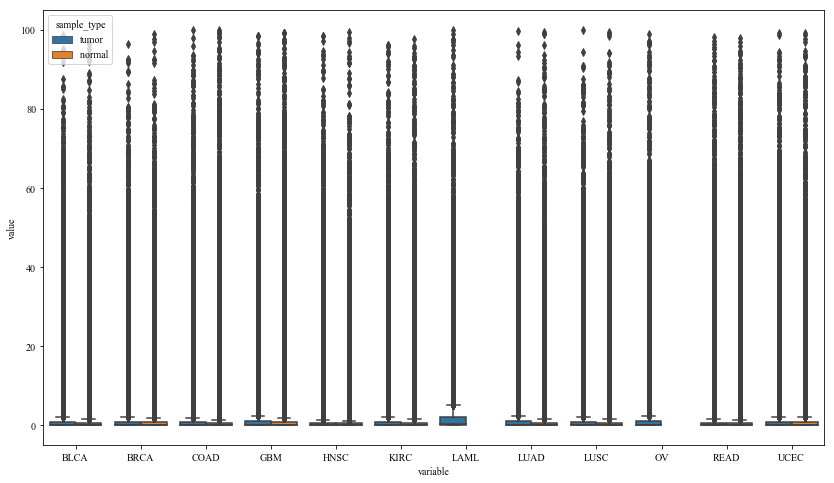

In [18]:
all_geneexpression = pd.concat((mean_ge_tumor_filtered, mean_ge_normal_filtered))
all_geneexpression['sample_type'] = ['tumor']*mean_ge_tumor_filtered.shape[0] + ['normal']*mean_ge_normal_filtered.shape[0]
t = pd.melt(all_geneexpression, id_vars='sample_type')

fig = plt.figure(figsize=(14, 8))
seaborn.boxplot(data=t, x='variable', y='value', hue='sample_type')

In [19]:
mean_ge_tumor_filtered.to_csv('../../data/pancancer/TCGA/expression/mean_matrix_filtered.tsv', sep='\t')
mean_ge_normal_filtered.to_csv('../../data/pancancer/TCGA/expression/mean_matrix_normaltissue_filtered.tsv', sep='\t')

## Compute Fold Changes compared to normal Tissue

In [21]:
fold_changes = []
ctype_no_normal = []
for c in mean_ge_tumor_filtered.columns:
    if c in mean_ge_normal_filtered:
        fc = np.log2(mean_ge_tumor_filtered[c] / mean_ge_normal_filtered[c])
    else:
        ctype_no_normal.append(c)
        fc = np.log2(mean_ge_tumor_filtered[c] / mean_ge_normal_filtered.mean(axis=1))
    fold_changes.append(fc)
fc_df = pd.DataFrame(fold_changes).T
fc_df.rename(columns={'Unnamed {}'.format(i): ctype_no_normal[i] for i in range(len(ctype_no_normal))}, inplace=True)

/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log2
/pkg/python-3.6.0-0/lib/python3.6/site-packages/ipykernel/__main__.py:8: RuntimeWarning: divide by zero encountered in log2


In [22]:
fc_df.replace([np.inf, -np.inf], np.nan, inplace=True)
print ("No FoldChanges computable for {} genes. Left with {} genes.".format(fc_df[fc_df.isnull().any(axis=1)].shape[0], fc_df[~fc_df.isnull().any(axis=1)].shape[0]))

No FoldChanges computable for 21579 genes. Left with 31178 genes.


## Get Gene Names for Ensembl IDs
Lastly, I want to only look at a relatively small subset of the genes. I can get the gene names for all of the Ensembl IDs and then merge those that correspond to the same one (isoforms and alternative transcripts) since I don't have that kind of resolution in my network anyways.

In [25]:
if use_foldchanges:
    mean_matrix = fc_df
else:
    mean_matrix = mean_ge_tumor_filtered
print ("Using {} as data".format('FPKM' if not use_foldchanges else 'Fold Changes'))

Using Fold Changes as data


In [26]:
# now, join the two and remove gene when it does not fit
mean_matrix_symbol = mean_matrix.join(ens_2_symbol, on='ID')
mean_matrix_symbol.dropna(axis=0, inplace=True)

# merge genes with the same name
mean_matrix_symbol_joined = mean_matrix_symbol.drop('ID', axis=1).groupby('Name').mean()

# add IDs again (column was lost during grouping)
mean_matrix_final = ens_2_symbol.join(mean_matrix_symbol_joined, on='Name')

# write to file
mean_matrix_final.to_csv('../../data/pancancer/TCGA/expression/mean_matrix_names_{}.tsv'.format('fc' if use_foldchanges, sep='\t')

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-11000...done.
querying 11001-12000...done.
querying 12001-13000...done.
querying 13001-14000...done.
querying 14001-15000...done.
querying 15001-16000...done.
querying 16001-17000...done.
querying 17001-18000...done.
querying 18001-19000...done.
querying 19001-20000...done.
querying 20001-21000...done.
querying 21001-22000...done.
querying 22001-23000...done.
querying 23001-24000...done.
querying 24001-25000...done.
querying 25001-26000...done.
querying 26001-27000...done.
querying 27001-28000...done.
querying 28001-29000...done.
querying 29001-30000...done.
querying 30001-31000...done.
querying 31001-32000...done.
querying 32001-33000...done.
querying 33001-34000...done.
querying 34001-35000...done.
queryin

In [27]:
# next, look how many genes will get symbols
mean_matrix['ID'] = [i[0] for i in mean_matrix.index.str.split('.')]
no_matches = mean_matrix[mean_matrix.ID.isin(ens_2_symbol.index)].shape[0]
print ("Found symbols for {} of {} genes".format(no_matches, mean_matrix.shape[0]))

Found symbols for 49565 of 52757 genes


In [28]:
# now, join the two and remove gene when it does not fit
mean_matrix_symbol = mean_matrix.join(ens_2_symbol, on='ID')
mean_matrix_symbol.dropna(axis=0, inplace=True)

# merge genes with the same name
mean_matrix_symbol_joined = mean_matrix_symbol.drop('ID', axis=1).groupby('Name').mean()

# add IDs again (column was lost during grouping)
mean_matrix_final = ens_2_symbol.join(mean_matrix_symbol_joined, on='Name')

# write to file
mean_matrix_final.to_csv('../../data/pancancer/TCGA/expression/mean_matrix_names_{}.tsv'.format('fc' if use_foldchanges else 'fpkm'),
                         sep='\t')

## Remove Genes that are not in Network

In [29]:
with h5py.File('../../data/pancancer/hotnet_iref_vec_input_unbalanced.h5', 'r') as f:
    network = f['network'][:]
    features = f['features'][:]
    node_names = f['gene_names'][:]
    y_train = f['y_train'][:]
    y_test = f['y_test'][:]
    if 'y_val' in f:
        y_val = f['y_val'][:]
    else:
        y_val = None
    train_mask = f['mask_train'][:]
    test_mask = f['mask_test'][:]
    if 'mask_val' in f:
        val_mask = f['mask_val'][:]
    else:
        val_mask = None

In [30]:
mean_matrix_final[mean_matrix_final.Name.isin(node_names[:, 1])].shape, node_names.shape

((9704, 13), (12129, 2))

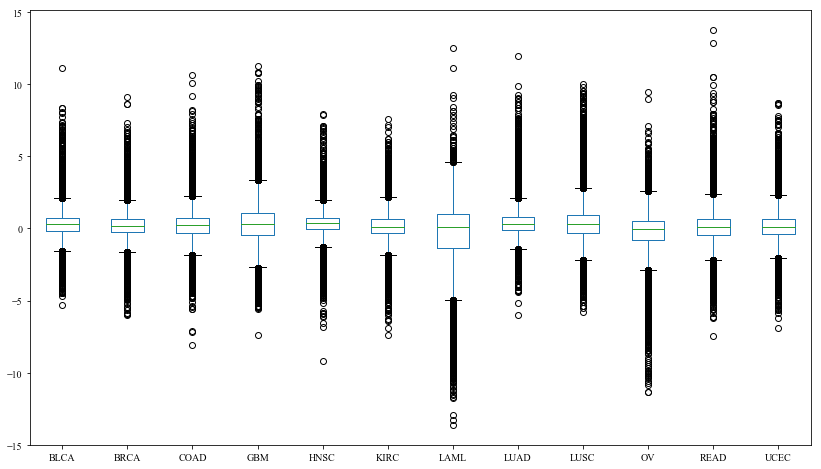

In [31]:
features_ge = mean_matrix_final[mean_matrix_final.Name.isin(node_names[:, 1])]
features_ge.plot(kind='box', figsize=(14, 8))

## Write Back to Disk
Last but not least, I write the gene expression back as features to disk. I can then use the container for multi-omics training but also train on the container only.

In [32]:
# first, bring node names to DF
nodes_df = pd.DataFrame(node_names, columns=['ensembl_id', 'name'])
nodes_df.set_index('name', inplace=True)

# add gene body and promoter information
F = nodes_df.join(features_ge.set_index('Name'))

num_of_zero_nodes = F.isnull().any(axis=1).sum()
print ("{} out of {} nodes don't have any features assigned".format(num_of_zero_nodes, network.shape[0]))
print ("--> left with valid scores for {} genes".format(network.shape[0]-num_of_zero_nodes))

# put 0 for missing data and remove name columns
F.fillna(0, inplace=True)
F.drop('ensembl_id', axis=1, inplace=True)
F = F[~F.index.duplicated()]

3094 out of 12129 nodes don't have any features assigned
--> left with valid scores for 9035 genes


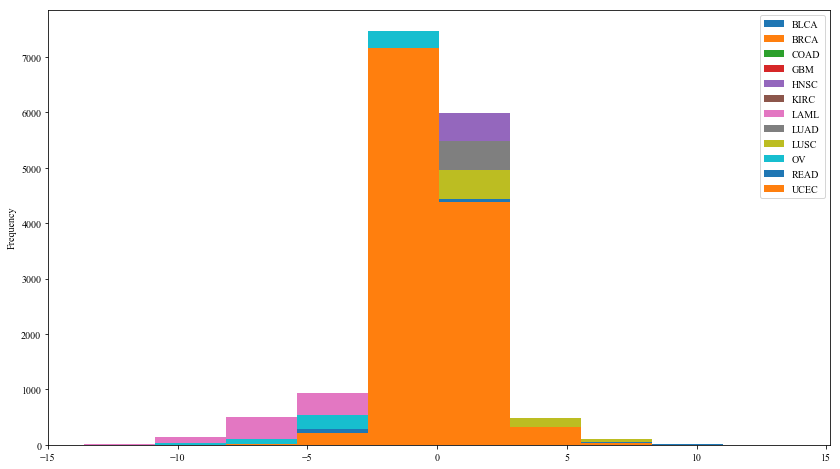

In [33]:
F.plot(kind='hist', figsize=(14, 8))

In [34]:
features = F.as_matrix()
feature_names = np.array(['blca', 'brca', 'coad', 'gbm', 'hnsc', 'kirc',
                         'laml', 'luad', 'lusc', 'ov', 'read', 'ucec'],
                        dtype=object)
string_dt = h5py.special_dtype(vlen=str)

fname = '../../data/pancancer/iref_tcga_expression_filter{}_{}.h5'.format(max_reads, 'fc' if use_foldchanges else 'fpkm')
f = h5py.File(fname, 'w')

# add ppi network
f.create_dataset('network', data=network, shape=network.shape)

# add features
f.create_dataset('features', data=features, shape=features.shape)

# add gene names (same order as features & network)
f.create_dataset('gene_names', data=node_names, dtype=string_dt)
# add labels
f.create_dataset('y_train', data=y_train, shape=y_train.shape)
f.create_dataset('y_test', data=y_test, shape=y_test.shape)
if y_val is not None:
    f.create_dataset('y_val', data=y_val, shape=y_val.shape)

f.create_dataset('mask_train', data=train_mask, shape=train_mask.shape)
f.create_dataset('mask_test', data=test_mask, shape=test_mask.shape)
if y_val is not None:
    f.create_dataset('mask_val', data=val_mask, shape=val_mask.shape)
f.create_dataset('feature_names', data=feature_names, dtype=string_dt)

f.close()
print ("Container written to {}".format(fname))

Container written to ../../data/pancancer/iref_tcga_expression_filter100_fc.h5


## Compute Embedding of Sample-Wise Gene Expression

In [36]:
samples_with_ctype.drop('ID')

,0,1,2,3,4,5,6,7,8,9,...,53352,53353,53354,53355,53356,53357,53358,53359,cancertype,sample_type_simple
ID,ENSG00000242268.2,ENSG00000270112.3,ENSG00000167578.15,ENSG00000273842.1,ENSG00000078237.5,ENSG00000146083.10,ENSG00000225275.4,ENSG00000158486.12,ENSG00000198242.12,ENSG00000259883.1,...,ENSGR0000182162.8,ENSG00000264793.1,ENSG00000226507.1,ENSG00000224551.1,ENSG00000139083.9,ENSG00000279880.1,ENSG00000223496.2,ENSG00000082996.18,NaN,NaN
6449f2b6-1af9-4612-abde-ac0f5bb1ff7e.FPKM.txt.gz,0.062428,0,4.29504,0,6.53202,16.7663,0,0.211842,106.336,0.201211,...,0,0,0,0,9.09031,0.103609,6.10711,28.2344,LUAD,tumor
d7e7ad52-ecde-4744-b4e7-28dea4d186da.FPKM.txt.gz,0.0599828,0.0083228,1.47837,0,1.60602,13.1475,0,0.0113871,136.857,0.460309,...,0,0,0.0498103,0,3.8023,0.0530937,6.01942,29.4814,KIRC,tumor
b57f69a6-91ca-4131-a654-5495f6dd1131.FPKM.txt.gz,0,0,3.67859,0,5.05888,22.4423,0,0.246391,165.359,0.0678129,...,0,0,0.0305753,0,10.2314,0.134437,8.15253,16.8574,COAD,tumor
591271df-af96-4915-9e17-e3362bb7f57d.FPKM.txt.gz,0.113754,0.0063135,0.984695,0,1.96637,9.95442,0,0.00647851,239.213,0.230459,...,0,0,0,0,4.76031,0.0226551,6.23805,20.6724,KIRC,tumor


In [37]:
embedding = TSNE(n_components=2).fit_transform(samples_with_ctype.drop(['cancertype', 'sample_type_simple'], axis=1).drop('ID'))

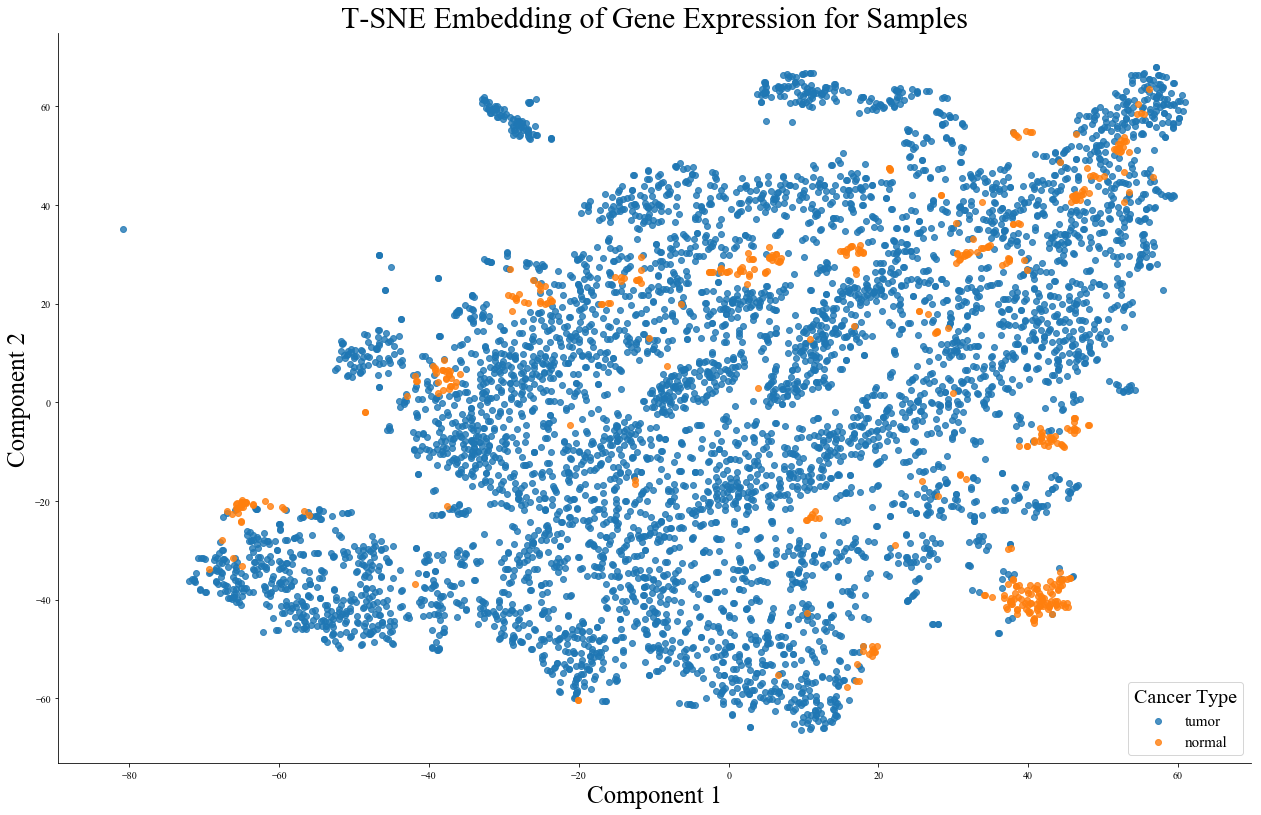

In [53]:
long = pd.DataFrame(embedding, columns=['pc1', 'pc2'], index=samples_with_ctype.drop('ID').index)
long['cancertype'] = samples_with_ctype.cancertype
long['sampletype'] = samples_with_ctype.sample_type_simple
tumor_long = long[long.sampletype == 'tumor']
g = seaborn.lmplot(x='pc1', y='pc2', data=long, hue='sampletype', fit_reg=False, legend=False)
g.fig.set_size_inches(20, 12)
g.ax.set_xlabel('Component 1', fontsize=25)
g.ax.set_ylabel('Component 2', fontsize=25)
g.ax.legend(loc='lower right', fontsize=15, title='Cancer Type')
plt.setp(g.ax.get_legend().get_title(), fontsize=20)
plt.title('T-SNE Embedding of Gene Expression for Samples', fontsize=30)
g.fig.savefig('../../data/pancancer/TCGA/expression/tsne_geneexpression_tumor_vs_normal.png', dpi=300)

In [364]:
F[F.index == 'MYOC']

,BLCA,BRCA,COAD,GBM,HNSC,KIRC,LAML,LUAD,LUSC,OV,READ,UCEC
MYOC,-5.272242,-3.464976,-4.709007,0.575686,-6.104471,1.041595,-7.559433,-4.366922,-3.11447,-3.583015,-4.941725,-1.012455
